<a href="https://colab.research.google.com/github/2021-FIIT-Bc-projects/BP-Fagan-CNN-Huby/blob/main/Experiment_1_FINAL_vlastny_model_1vs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/train_1vs1"
VALIDATION_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/validation_1vs1"
TEST_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/test_1vs1"

In [4]:
!cp -r "$TRAIN_DATA_DIR_GDRIVE" .
!cp -r "$VALIDATION_DATA_DIR_GDRIVE" .
!cp -r "$TEST_DATA_DIR_GDRIVE" .

In [32]:
TRAIN_DATA_DIR = './train_1vs1'
VALIDATION_DATA_DIR = './validation_1vs1'
TEST_DATA_DIR = './test_1vs1'

TRAIN_DATASET_PATH = pathlib.Path(TRAIN_DATA_DIR)
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA_DIR)
TEST_DATASET_PATH = pathlib.Path(TEST_DATA_DIR)

In [33]:
BATCH_SIZE = 32
IMG_SIZE=(180, 180)

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2355 files belonging to 2 classes.
Found 60 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


In [26]:
class_names = train_ds.class_names
print(class_names)

['E_Boletus_reticulatus', 'P_Amanita_muscaria']


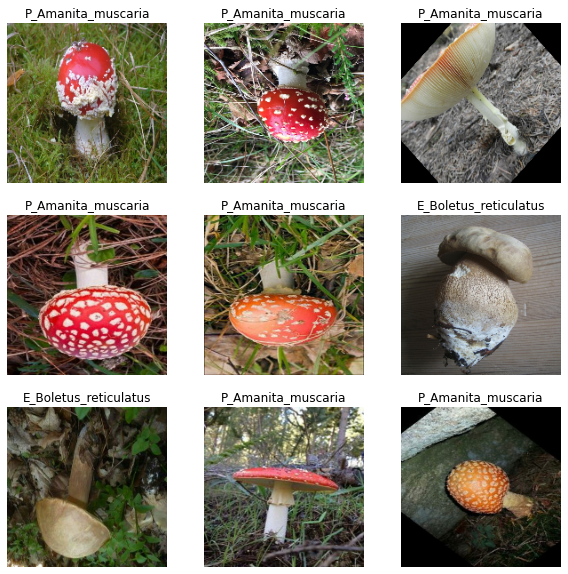

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
model = Sequential()

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0009),
              metrics=['accuracy'])

In [37]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    shuffle=True)

Epoch 1/5
74/74 [==============================] - 49s 337ms/step - loss: 2.5846 - accuracy: 0.8624 - val_loss: 39.8210 - val_accuracy: 0.8667
Epoch 2/5
74/74 [==============================] - 25s 333ms/step - loss: 0.1581 - accuracy: 0.9486 - val_loss: 2.1895 - val_accuracy: 0.9333
Epoch 3/5
74/74 [==============================] - 25s 332ms/step - loss: 0.0793 - accuracy: 0.9741 - val_loss: 0.1300 - val_accuracy: 0.9500
Epoch 4/5
74/74 [==============================] - 25s 332ms/step - loss: 0.0591 - accuracy: 0.9779 - val_loss: 0.1117 - val_accuracy: 0.9667
Epoch 5/5
74/74 [==============================] - 25s 332ms/step - loss: 0.0204 - accuracy: 0.9928 - val_loss: 0.0884 - val_accuracy: 0.9833


In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, None, None, 128)   3584      
                                                                 
 activation_15 (Activation)  (None, None, None, 128)   0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, None, None, 128)  512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, None, None, 128)   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 256)  

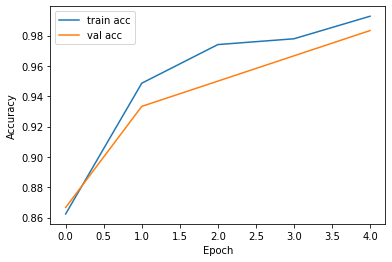

In [38]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

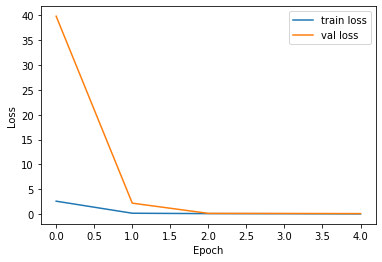

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluácia vytrénovaného modelu

In [40]:
test_loss, test_accuracy = model.evaluate(test_ds,batch_size=BATCH_SIZE)
print("Testovacia loss {0:.2f}, Testovacia accuracy {1:.2f}%".format(test_loss, test_accuracy * 100))

2/2 [==============================] - 0s 121ms/step - loss: 0.0884 - accuracy: 0.9833
Testovacia loss 0.09, Testovacia accuracy 98.33%


In [41]:
test_datagen = ImageDataGenerator()

test_dataset = test_datagen.flow_from_directory(
      TEST_DATASET_PATH, 
      target_size=IMG_SIZE, 
      class_mode='categorical', 
      batch_size=BATCH_SIZE, 
      shuffle=False
)

Found 60 images belonging to 2 classes.


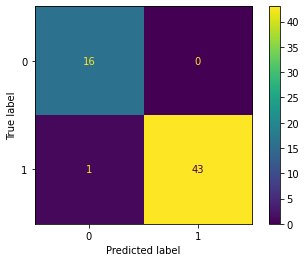

In [47]:
Y_true_classes = test_dataset.classes
Y_predict = model.predict(test_dataset)

Y_pred_classes = np.argmax(Y_predict, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_true_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=CONFUSION_MATRIX)

disp = disp.plot()

In [43]:
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.98      0.99        44

    accuracy                           0.98        60
   macro avg       0.97      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



In [44]:
def predict_and_evaluate():
  #test_data_batch = np.array(test_dataset)
  #print(test_data_batch.shape)

  predictions = model.predict(test_dataset)
  predicted_labels = np.argmax(predictions, axis=1)

  labels = test_dataset.classes
  class_indices = test_dataset.class_indices
  class_names = list(class_indices.keys())

  hits = 0

  for predicted_label, prediction, label in zip(predicted_labels, predictions, labels):
    probability = np.max(prediction) * 100
    print(
        '{} with {:.2f}% probability (real class: {})'.format(
            class_names[predicted_label],
            probability,
            class_names[label]
        )
    )

    hits = hits + 1 if label == predicted_label else hits

  accuracy = (hits / len(labels)) * 100
  return accuracy, predicted_labels

predict_and_evaluate()

E_Boletus_reticulatus with 100.00% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 97.41% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.90% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.95% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.82% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.96% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 100.00% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.41% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 100.00% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.99% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 99.99% probability (real class: E_Boletus_reticulatus)
E_Boletus_reticulatus with 95.82% probability (real class: E_Boletus_reticulatus)
E_Boletus_ret

(98.33333333333333,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [45]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/model_1vs1_testLoss00_testAcc98.h5')

In [ ]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/model_1vs1')
model_loaded.summary()